In [36]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import plotly.express as px

# Data
import pandas as pd
import numpy as np
import random

import sys
sys.path.insert(0, '../src')
from data.collector.brasil_bitcoin import LoadBrasilBitcoin
from data.collector.mercado_bitcoin import LoadMercadoBitcoin
from data.collector.ripio_bitcoin import LoadRipioTrade
from data.collector.bitcoin_to_you import LoadBitcoinToYou
from data.collector.bitypreco_bitcoin import LoadBityBitcoin
from data.collector.bitso_bitcoin import LoadBitsoBitcoin

## Functions

In [37]:
def area_plot(df, title=''):

    df_plt = df.groupby(['empresa', 'preco']).sum().reset_index()
    fig = px.area(df, x='preco', y='quantidade', line_group='empresa', color='empresa', width=700, height=500)


    fig.update_traces(mode='lines', 
                      hovertemplate='R$%{:,2f} <br>'.join([
                          '%{y:.2f} BTC',]))

    fig.update_layout(
        xaxis_title='Price',
        template='plotly_white',
        hovermode='x unified',
        title=title,
        showlegend=False,
        margin=dict(l=50, r=20, t=30, b=30)
    )
    fig.show()


def necessary_quantity(df, price=None, change=1, empresa=''):

    df_compras = df.query(f'empresa == "{empresa}" & compra_venda == "compra"')[['preco', 'quantidade']]
    df_vendas = df.query(f'empresa == "{empresa}" & compra_venda == "venda"')[['preco', 'quantidade']]

    if price == None:
        # Maior preço de compra e menor preço de venda
        best_ask_sell = [df_compras.preco.max(), df_vendas.preco.min()]
        price = np.mean(best_ask_sell)

    target_price = price * (1 + change/100)
    
    # quantidade acumulada até chegar ao valor alvo.
    quantidade_compra = df_compras.set_index('preco').cumsum().reset_index().query(f'preco <= {target_price}').iloc[0].quantidade

    quantidade_venda = df_vendas.set_index('preco').cumsum().reset_index().query(f'preco >= {target_price}').iloc[0].quantidade

    return [quantidade_compra, quantidade_venda]

## Load Data

In [38]:
lbb = LoadBrasilBitcoin()
brasil_data = lbb.get_brasil_bitcoin_orderbook()


lmb = LoadMercadoBitcoin()
mercado_data = lmb.get_mercado_bitcoin_orderbook()

lrt = LoadRipioTrade()
ripio_data = lrt.get_ripio_bitcoin_orderbook()

bitso = LoadBitsoBitcoin()
bitso_data = bitso.get_bitso_bitcoin_orderbook()

bity = LoadBityBitcoin()
bity_data = bity.get_bity_bitcoin_orderbook()


#b2u = LoadBitcoinToYou()  -  Valores Estranhos
#b2u_data = b2u.get_btou_bitcoin_orderbook()


In [39]:
# bitso_data.rename(columns={''}).isnull().sum()

In [40]:
bitso_data = bitso_data.rename(columns={'book': 'id', 'price': 'preco', 'amount': 'quantidade'})
bity_data = bity_data.rename(columns={'amount': 'quantidade', 'price': 'preco'})#.isnull().sum()

In [41]:
bitcoin_df = pd.concat([brasil_data, ripio_data, 
                        mercado_data, 
                        bitso_data, 
                        bity_data
                        ])
bitcoin_df['preco'] = bitcoin_df['preco'].astype(float).astype(int)
bitcoin_df['quantidade'] = bitcoin_df['quantidade'].astype(float)

In [42]:
bitcoin_df.sort_values('preco', ascending=False)

,preco,quantidade,compra_venda,empresa,id,valor
44,948654,0.004333,venda,Bitso Bitcoin,NaN,NaN
43,931380,1.000000,venda,Bitso Bitcoin,NaN,NaN
42,260625,0.005514,venda,Bitso Bitcoin,NaN,NaN
41,227990,0.106489,venda,Bitso Bitcoin,NaN,NaN
40,225850,0.115000,venda,Bitso Bitcoin,NaN,NaN
...,...,...,...,...,...,...
46,185001,0.027027,compra,Brasil Bitcoin,NaN,NaN
48,185000,0.001455,compra,Brasil Bitcoin,NaN,NaN
47,185000,0.000396,compra,Brasil Bitcoin,NaN,NaN
49,185000,0.000340,compra,Brasil Bitcoin,NaN,NaN


In [44]:
area_plot(bitcoin_df.query('compra_venda == "venda"'), title='Ordem de Vendas')

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [ ]:
maior_preco_compra = bitcoin_df.query('compra_venda == "compra"').preco.max()
menor_preco_venda = brasil_data.query('compra_venda == "venda"').preco.min()

best_ask_sell = [maior_preco_compra, menor_preco_venda]

# Preco
P = np.mean(best_ask_sell)

In [ ]:
empresas = bitcoin_df['empresa'].unique()
 
price_changes_qt = {f'{empresa}': necessary_quantity(df=bitcoin_df, change=1, empresa=empresa) for empresa in empresas}
changes = pd.DataFrame(price_changes_qt).T.reset_index().rename(columns={0: 'quantidade_compra', 1:'quantidade_venda', 'index': 'empresa'})

In [ ]:
changes

,empresa,quantidade_compra,quantidade_venda
0,Brasil Bitcoin,7.249864e-02,1.521454
1,Ripio Trade,6.600000e-07,0.181428
2,Mercado Bitcoin,4.500000e-03,3.887645
3,Bitso Bitcoin,2.797205e-02,3.396470
4,Bity Preço,5.033068e-01,3.212165


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

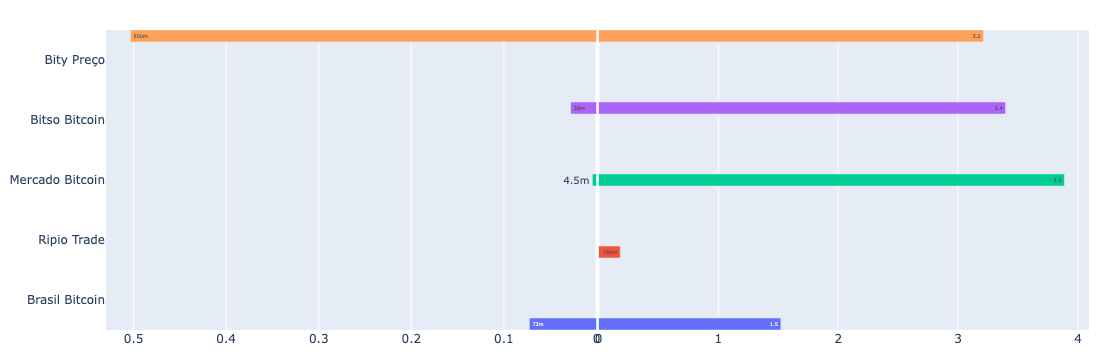

In [ ]:
compra_qtd = px.bar(data_frame=changes, x='quantidade_compra', y='empresa', color='empresa', title='Quantidade de necessária para mudar o preço em 1 %.', width=600, height=400, text='quantidade_compra')

venda_qtd = px.bar(data_frame=changes, x='quantidade_venda', y='empresa', color='empresa', title='Quantidade de necessária para mudar o preço em 1 %.', width=600, height=300, labels=None, text='quantidade_venda')


compra_qtd.update_traces(texttemplate='%{text:.2s}')
venda_qtd.update_traces(texttemplate='%{text:.2s}')
fig = make_subplots(rows=1, cols=2, horizontal_spacing=0.002)

n = len(empresas)

for i in range(n):
    fig.add_trace(compra_qtd.data[i], row=1, col=1)
    fig.add_trace(venda_qtd.data[i], row=1, col=2)

fig.update_layout(xaxis=dict(autorange='reversed'),
                  showlegend=False,
                  margin=dict(l=10, r=10, t=30, b=30),
                  yaxis2=dict(visible=False),
                  bargap=0
                  )